In [1]:
import numpy as np
import math
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
learning_rate = 0.01

In [3]:
def trapezoidIntegral(vals, ds):
    pass1 = tf.reduce_sum(vals, axis=0)
    pass2 = tf.reduce_sum(vals[1:-1], axis=0)
    return ds/2.0*(pass1+pass2)
def TFconv(image, filt, b):
    return tf.nn.convolution(input=image, filters=filt, padding="SAME") + b

In [4]:
def TFuSoln(raw_u0, ds, inFilt, pFilt, b, optimizer):
    with tf.GradientTape() as tape:
        bzero = tf.zeros([inFilt.shape[4]])
        tape.watch(raw_u0)
        u0 = TFconv(raw_u0, inFilt[0], bzero)
        #for loop begins, h=0
        x0 = tf.nn.leaky_relu(u0, alpha=0.1)
        zInt0 = TFconv(x0, pFilt[0,0], b[0] / ((0+1)*ds))
        z0 = trapezoidIntegral(zInt0, ds)
        u1 = z0 + TFconv(raw_u0, inFilt[1], bzero)
        
        #h=1
        x1 = tf.nn.leaky_relu(u1, alpha=0.1)
        zInt1_0 = TFconv(x0, pFilt[0,1], b[1] / ((1+1)*ds)) #s=0
        zInt1_1 = TFconv(x1, pFilt[1,1], b[1] / ((1+1)*ds)) #s=1
        zInt1 = tf.stack([zInt1_0, zInt1_1])
        z1 = trapezoidIntegral(zInt1, ds)
        u2 = z1 + TFconv(raw_u0, inFilt[2], bzero)
        #h=2
        x2 = tf.nn.leaky_relu(u2, alpha=0.1)#
        zInt2_0 = TFconv(x0, pFilt[0,2], b[2] / ((2+1)*ds)) #s=0
        zInt2_1 = TFconv(x1, pFilt[1,2], b[2] / ((2+1)*ds)) #s=1
        zInt2_2 = TFconv(x2, pFilt[2,2], b[2] / ((2+1)*ds)) #s=2
        zInt2 = tf.stack([zInt2_0, zInt2_1, zInt2_2])
        z2 = trapezoidIntegral(zInt2, ds)#
        u3 = z2 + TFconv(raw_u0, inFilt[3], bzero)
        #h=3
        x3 = tf.nn.leaky_relu(u3, alpha=0.1)
        zInt3_0 = TFconv(x0, pFilt[0,3], b[3] / ((3+1)*ds)) #s=0
        zInt3_1 = TFconv(x1, pFilt[1,3], b[3] / ((3+1)*ds)) #s=1
        zInt3_2 = TFconv(x2, pFilt[2,3], b[3] / ((3+1)*ds)) #s=2
        zInt3_3 = TFconv(x3, pFilt[3,3], b[3] / ((3+1)*ds)) #s=3
        zInt3 = tf.stack([zInt3_0, zInt3_1, zInt3_2, zInt3_3])
        z3 = trapezoidIntegral(zInt3, ds)
        u4 = z3 + TFconv(raw_u0, inFilt[4], bzero)
        #end loop
        x4 = tf.nn.leaky_relu(u4, alpha=0.1)
        
        loss = tf.math.square(u4 - raw_u0)
        #print("Loss: ", tf.math.reduce_sum(loss))
        #[dl_dpFilt, dl_dinFilt, dl_db] = tape.gradient(loss, [pFilt, inFilt, b])
        #print(tf.transpose(dl_dpFilt, perm=[0,1,4,5,2,3]))
        #print(difference_sq)
        gradients = tape.gradient(loss, [pFilt, inFilt, b])
        #print("Before gradient:", b)
        optimizer.apply_gradients(zip(gradients, [pFilt, inFilt, b]))
        #print("After gradient:", b)
        return tf.math.reduce_sum(loss)
    
    #x = tf.stack([x0,x1,x2,x3,x4])
    #u = tf.stack([u0,u1,u2,u3,u4])
    
    #return x,u

In [5]:
t0 = 4
t1 = t0+1
dt = 1.0/t0
input_shape = (1,5,5)
filter_shape = (1,1,3,3)



actWt = [.1, 1] #leakyRelU: first number is slope left of origin, second number is slope right of origin

rng = np.random.default_rng(42)
uIn = rng.random(input_shape, dtype=np.float32)
iFilt = rng.random((t1,*filter_shape), dtype=np.float32)
paramFilt = rng.random((t1,t1,*filter_shape), dtype=np.float32)
biasVec = rng.random((t1,1), dtype=np.float32)

#xOut, uOut = uSoln(uIn, dt, iFilt, paramFilt, biasVec)
print(uIn)

[[[0.08925092 0.77395594 0.6545714  0.43887842 0.43301523]
  [0.8585979  0.08594561 0.697368   0.20146942 0.09417725]
  [0.5264789  0.9756223  0.73575234 0.76113963 0.7174772 ]
  [0.78606427 0.5132265  0.12811363 0.83974814 0.45038593]
  [0.5003519  0.370798   0.1825496  0.92676497 0.78156745]]]


In [6]:
TFuIn = tf.expand_dims(tf.transpose(tf.convert_to_tensor(uIn, dtype=tf.float32), perm=[1,2,0]), 0)

TFiFiltTensor = tf.transpose(tf.compat.v1.get_variable("iFiltTensor", initializer=iFilt), perm=[0,3,4,1,2])
TFiFilt = tf.Variable(TFiFiltTensor, name="iFilt")

TFpFiltTensor = tf.transpose(tf.compat.v1.get_variable("pFiltTensor", initializer=paramFilt), perm=[0,1,4,5,2,3])
TFpFilt = tf.Variable(TFpFiltTensor, name="pFilt")

TFbiasVec = tf.compat.v1.get_variable("biasVec", initializer=biasVec)

opt = tf.keras.optimizers.Adam(learning_rate)

iterations = 200
losses = []
for i in np.arange(iterations):
    losses.append(TFuSoln(TFuIn, dt, TFiFilt, TFpFilt, TFbiasVec, opt).numpy())

In [7]:
#print(tf.transpose(TFuOut, perm=[4,0,1,2,3]))

Text(0, 0.5, 'Simple Sum Loss')

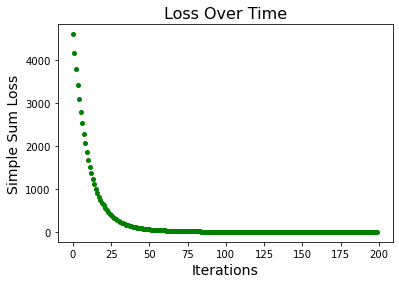

In [8]:
plt.plot(losses, "go", ms=4)
plt.title("Loss Over Time", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Simple Sum Loss", fontsize=14)
#plt.xlim([0, iterations+1])
#plt.ylim([0,40])

In [9]:
losses[99]

9.222268